# Описание проекта: телекоммуникации

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентовронный чек.

#### Описание услуг

Оператор предоставляет два основных типа услуг:   
Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.  
Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).  

Также доступны такие услуги:  

Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);  
Выделенная линия технической поддержки (TechSupport);  
Облачное хранилище файлов для резервного копирования данных (OnlineBackup);  
Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).  

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

---
Цель работы: создание модели, которая будет предсказывать, разорвёт ли абонент договор.

План выполнения работы:

- Загрузка и первичный осмотр данных
- Исследовательский анализ; предобработка данных
- Подготовка данных к обчению моделей, кодирование и масштабирование признаков
- Обучение моделей, сравнение результатов на кросс-валидации
- Тестирование лучшей модели на тестовой выборке
- Вывод

---

In [1]:
!pip install -q phik
!pip install -U -q scikit-learn
!pip install -U -q matplotlib
!pip install -U -q seaborn

In [2]:
import warnings
warnings.filterwarnings("ignore") 

In [3]:
import os
import time


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import RandomizedSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier

RANDOM_STATE = 220424
PIE_COLORS = ['LightGray',
             'LightCoral',
             'LightBlue',
             'LightGreen']

In [4]:
%%capture
!pip install catboost
from catboost import CatBoostClassifier

In [5]:
path_template_local = 'C:\\Users\\Учеба\\Desktop\\anaconda\\datasets\\'
path_template_YP = '/datasets/'

In [6]:
# Вспомогательные функции
def read_data(name, path1=path_template_local, path2=path_template_YP):
    ''' Сохранить данные в переменные '''
    if os.path.exists(path2+name):
        data = pd.read_csv(path2+name+'.csv')
    else:
        data = pd.read_csv(path1+name+'.csv')
    return data

def data_init_info(data):
    ''' Первичный осмотр данных '''
    print('Полных дубликатов: ', data.duplicated().sum(), '\n', '*'*30),
    print('Пропусков: \n', data.isna().sum(), '\n', '*'*30),  
    data.info(),
    print('*'*30),
    #display(data.describe()),
    #print('*'*30),    
    display(data.head(3))

## Загрузка данных и первичный осмотр

In [7]:
data_contract = read_data('contract_new')
data_internet = read_data('internet_new')
data_personal = read_data('personal_new')
data_phone = read_data('phone_new')



#### contract_new

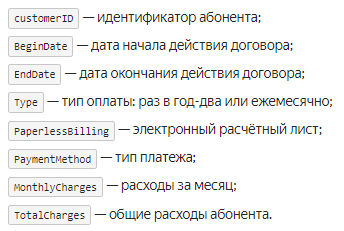

In [8]:
data_init_info(data_contract)

Полных дубликатов:  0 
 ******************************
Пропусков: 
 customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64 
 ******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
******************************


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17


В таблице 7043 записей о контрактах клиентов.  
Много данных типа object - это нужно будет скорее всего поправить.  
`EndDate` из этой таблицы скорее всего мой таргет, посмотрю на него внимательнее:

In [9]:
data_contract.EndDate.unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

In [10]:
target_count = data_contract.EndDate.apply(lambda x: 'Stayed' if x == 'No' else 'Dropped').value_counts()

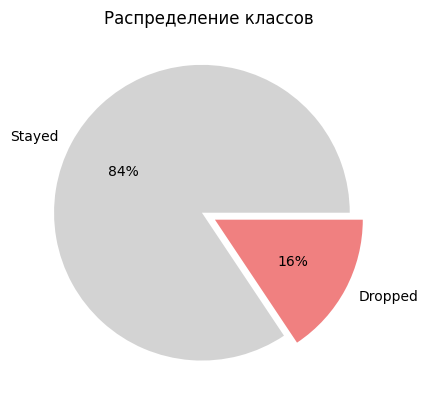

In [11]:
target_count.plot(title='Распределение классов',
                  kind='pie',
                  explode=(0.05, 0.05),
                  autopct='%1.0f%%',
                  ylabel='',
                  colors=PIE_COLORS);

In [12]:
def snek_columns(data):
    '''
    колонки к snake_case
    '''
    data.columns = (data.columns
                         .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                         .str.lower()
                    )
    return data

In [13]:
data_contract = snek_columns(data_contract)
data_contract.head(1)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04


In [14]:
# Cоздам новый столбец для target
data_contract['target'] = data_contract.end_date.apply(lambda x: 0 if x == 'No' else 1)
data_contract['target'].value_counts()

target
0    5942
1    1101
Name: count, dtype: int64

Поменяю типы данных с `object`, где это возможно:

In [15]:
data_contract.total_charges.unique()

array(['31.04', '2071.84', '226.17', ..., '325.6', '520.8', '7251.82'],
      dtype=object)

In [16]:
data_contract[data_contract.total_charges == ' '].customer_id.count()

11

В `TotalCharges`  есть пустые значения, их всего 11. Посмотрю на эти данные:

In [17]:
data_contract[data_contract.total_charges == ' '].head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,0


In [18]:
data_contract[data_contract.total_charges == ' '].begin_date.unique()

array(['2020-02-01'], dtype=object)

Похоже, это новые данные (информация о договорах актуальна на 1 февраля 2020 года по условию). Вычеркну их из датасета:

In [19]:
data_contract = data_contract[data_contract.total_charges != ' ']

In [20]:
data_contract.total_charges = data_contract.total_charges.astype(float)

`BeginDate` в datetime:

In [21]:
data_contract.begin_date = pd.to_datetime(data_contract.begin_date)

In [22]:
display(min(data_contract.begin_date),
        max(data_contract.begin_date))

Timestamp('2013-10-01 00:00:00')

Timestamp('2020-01-01 00:00:00')

Создам новый стоблец в таблице с количеством дней контракта:

In [23]:
data_contract['end'] = data_contract.end_date.apply(lambda x: '2020-02-01' if x == 'No' else x)
data_contract.end = pd.to_datetime(data_contract.end)

In [24]:
data_contract['days_qua'] = data_contract.end - data_contract.begin_date

In [25]:
data_contract['days_qua'] = data_contract['days_qua'].astype('timedelta64[s]').astype('int64')/86400

Добавлю еще один столбец - сколько дней до следующего пополнения баланса. Логика говорит, что люди скорее всего больше отказываются от услуг ближе к дате следующего платежа:

In [26]:
data_contract.type.unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [27]:
def days_before_payment(row):
    if row['type'] == 'Month-to-month':
        return row['days_qua']%30
    elif row['type'] == 'One year':
        return row['days_qua']%366
    return row['days_qua']%732

data_contract['days_until_next_pay'] = data_contract.apply(days_before_payment, axis=1)

In [28]:
display(data_contract.describe(),
        data_contract.head(3))

,begin_date,monthly_charges,total_charges,target,end,days_qua,days_until_next_pay
count,7032,7032.000000,7032.000000,7032.000000,7032,7032.000000,7032.000000
mean,2017-04-28 23:14:44.641638400,64.798208,2118.621822,0.156570,2019-10-15 22:19:02.662116096,899.961320,160.071388
min,2013-10-01 00:00:00,18.250000,19.050000,0.000000,2014-06-01 00:00:00,28.000000,0.000000
25%,2015-06-01 00:00:00,35.587500,439.745000,0.000000,2020-02-01 00:00:00,276.000000,6.000000
50%,2017-09-01 00:00:00,70.350000,1345.275000,0.000000,2020-02-01 00:00:00,761.000000,18.000000
75%,2019-04-01 00:00:00,89.862500,3239.317500,0.000000,2020-02-01 00:00:00,1461.000000,273.000000
max,2020-01-01 00:00:00,118.750000,9221.380000,1.000000,2020-02-01 00:00:00,2314.000000,731.000000
std,NaN,30.085974,2112.736199,0.363421,NaN,682.738777,225.405656


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,end,days_qua,days_until_next_pay
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0,2020-02-01,31.0,1.0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0,2020-02-01,1036.0,304.0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0,2020-02-01,123.0,3.0


#### personal_new

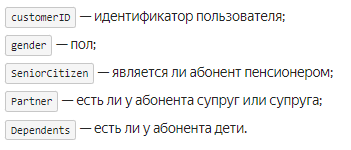

In [29]:
data_init_info(data_personal)

Полных дубликатов:  0 
 ******************************
Пропусков: 
 customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64 
 ******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
******************************


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


In [30]:
# Приведу колонки к snake_case
data_personal = snek_columns(data_personal)

In [31]:
# Приведу senior_citizen к виду остальных колонок
data_personal.senior_citizen = data_personal.senior_citizen.apply(lambda x: 'No' if x == 0 else 'Yes')

In [32]:
data_personal.senior_citizen.value_counts()

senior_citizen
No     5901
Yes    1142
Name: count, dtype: int64

В этой таблице находятся персональные карточки клиентов.

#### internet_new

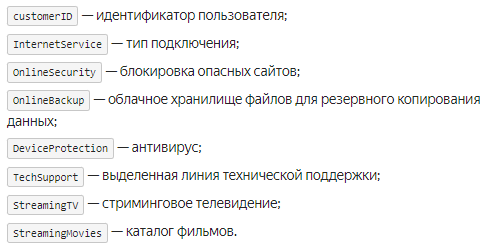

In [33]:
data_init_info(data_internet)

Полных дубликатов:  0 
 ******************************
Пропусков: 
 customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64 
 ******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
******************************


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


In [34]:
data_internet = snek_columns(data_internet)

#### phone_new

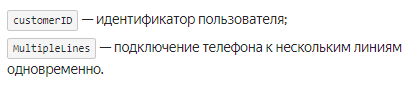

In [35]:
data_init_info(data_phone)

Полных дубликатов:  0 
 ******************************
Пропусков: 
 customerID       0
MultipleLines    0
dtype: int64 
 ******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
******************************


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


In [36]:
data_phone = snek_columns(data_phone)

## Объединение данных

Ключом для всех четырёх таблиц будет `customerID`.  
Просмотрю все таблицы на предмет повторения ключей:

In [37]:
datasets = [data_contract,
            data_personal,
            data_internet,
            data_phone]

In [38]:
for item in datasets:
    print(item.customer_id.nunique()),
    print(item.shape[0], '\n', '*'*30)

7032
7032 
 ******************************
7043
7043 
 ******************************
5517
5517 
 ******************************
6361
6361 
 ******************************


Все ключи в таблицах уникальные и их количество совпадает с количеством записей. Объединю все таблицы на основе `data_personal` по id клиентов:

In [39]:
data = data_personal.merge(data_contract, on='customer_id', how='inner')
data = data.merge(data_internet, on='customer_id', how='left')
data = data.merge(data_phone, on='customer_id', how='left')

In [40]:
data_init_info(data)

Полных дубликатов:  0 
 ******************************
Пропусков: 
 customer_id               0
gender                    0
senior_citizen            0
partner                   0
dependents                0
begin_date                0
end_date                  0
type                      0
paperless_billing         0
payment_method            0
monthly_charges           0
total_charges             0
target                    0
end                       0
days_qua                  0
days_until_next_pay       0
internet_service       1520
online_security        1520
online_backup          1520
device_protection      1520
tech_support           1520
streaming_tv           1520
streaming_movies       1520
multiple_lines          680
dtype: int64 
 ******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----   

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,...,days_qua,days_until_next_pay,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,Female,No,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,...,31.0,1.0,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,No,No,No,2017-04-01,No,One year,No,Mailed check,...,1036.0,304.0,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,No,No,No,2019-10-01,No,Month-to-month,Yes,Mailed check,...,123.0,3.0,DSL,Yes,Yes,No,No,No,No,No


Посмотрю на колонки, в которых есть пропуски:

In [41]:
for i in range(16, 22):
    print(data.columns[i]),
    print(data[data.columns[i]].unique()),
    print('*'*30)

internet_service
['DSL' 'Fiber optic' nan]
******************************
online_security
['No' 'Yes' nan]
******************************
online_backup
['Yes' 'No' nan]
******************************
device_protection
['No' 'Yes' nan]
******************************
tech_support
['No' 'Yes' nan]
******************************
streaming_tv
['No' 'Yes' nan]
******************************


Заменю все `nan` на `W/O`:

In [42]:
data = data.fillna('W/O')

Добавлю колонку с количеством подключенных сервисов:

In [43]:
def count_yes(row):
    return row.str.contains('Yes').sum()

In [44]:
data['sevice_quantity'] = data.iloc[:, 16:23].apply(count_yes, axis=1)

In [45]:
data.tail(1)

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,...,days_until_next_pay,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,sevice_quantity
7031,3186-AJIEK,Male,No,No,No,2014-08-01,No,Two year,Yes,Bank transfer (automatic),...,546.0,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,No,5


## Исследовательский анализ данных



In [46]:
data = data.drop('customer_id', axis=1)

In [47]:
target = ['target']
cat=['gender', 'senior_citizen', 'partner', 'dependents', 'type', 'paperless_billing',
     'payment_method', 'internet_service', 'online_security', 'online_backup', 'device_protection',
     'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines'] 
num=['monthly_charges', 'total_charges', 'days_qua', 'days_until_next_pay']

Посмотрю на матрицу корреляции в моем датасете

In [48]:
%%capture
phik_overview = data.phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'days_qua', 'days_until_next_pay'])
phik_overview.round(2)

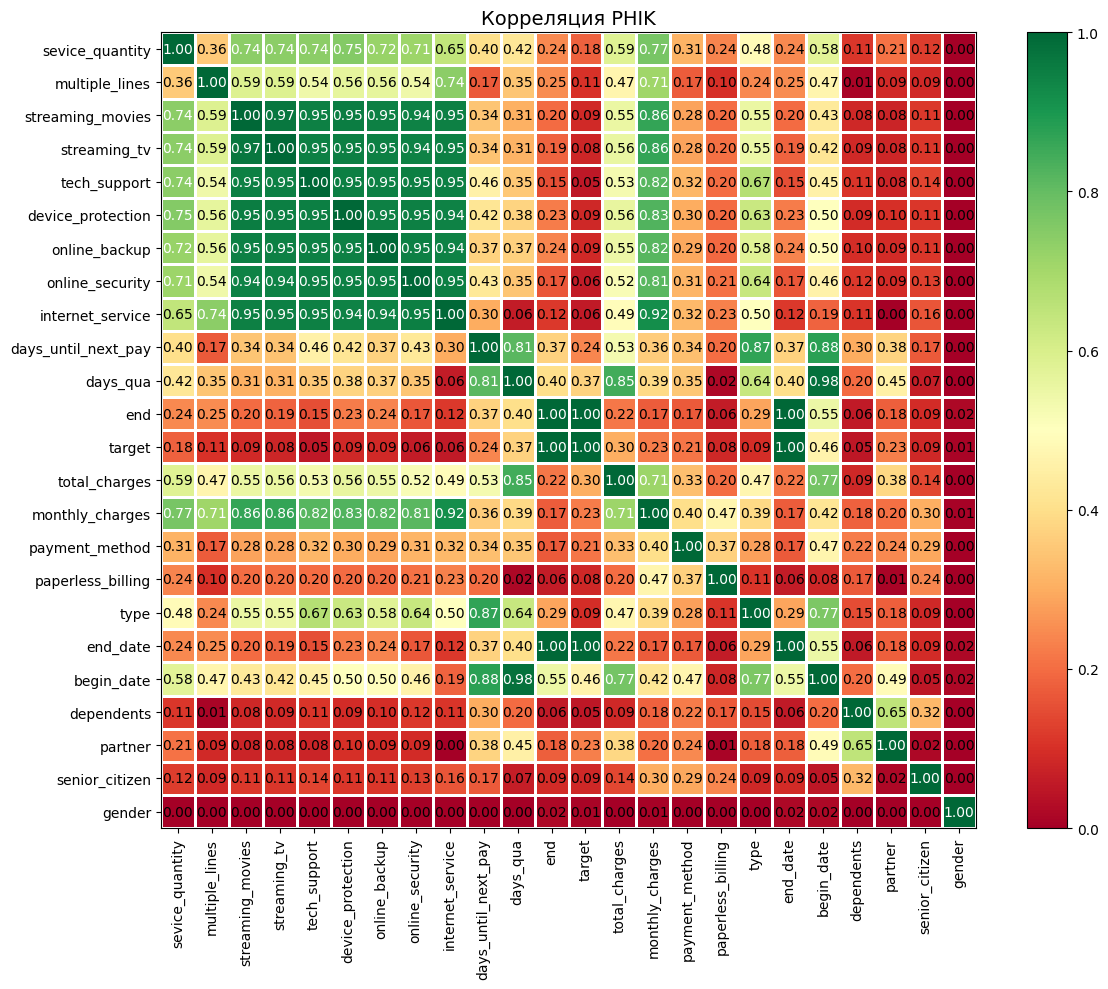

In [49]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0,
                        vmax=1, 
                        title='Корреляция PHIK',  
                        figsize=(12, 10)
                       )

plt.show()

Видно несколько логично зависимых друг от друга признаков: наличие сервисов, наличие партнера с наличием детей, оплата в месяц с подключеными сервисами, тип подписки с количеством сервисов.   
Есть зависимость между датой начала пользования сервисом и подключением доп опций, возможно связано с какими-то акциями компании.

#### Количественные признаки

Посмотрим на средние значения количественных переменных по группам **Dropped(1)/Stayed(0)**:

In [50]:
data[num+target].groupby(by=target).mean()

,monthly_charges,total_charges,days_qua,days_until_next_pay
target,,,,
0,62.803043,2071.701614,895.33856,155.600573
1,75.546004,2371.377275,924.86376,184.155313


Как ни странно, среднее количество дней контракта, сумма выплат всего и в месяц у людей, разорвавших контракт, больше, чем у оставшихся.

In [51]:
# Разделю данные на группы: ушли и остались
dropped=data[cat+num+target].query('target == 1')
stayed=data[cat+num+target].query('target == 0')

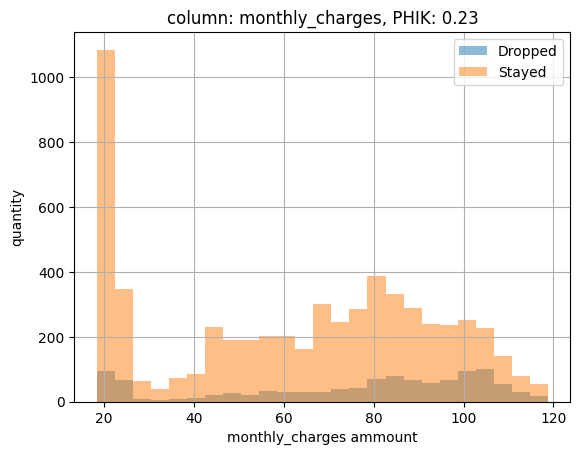

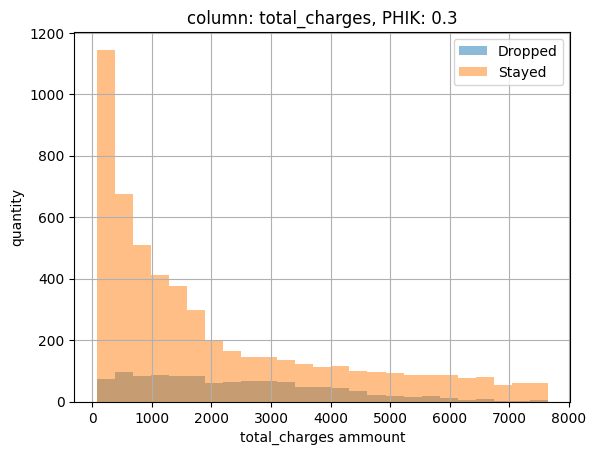

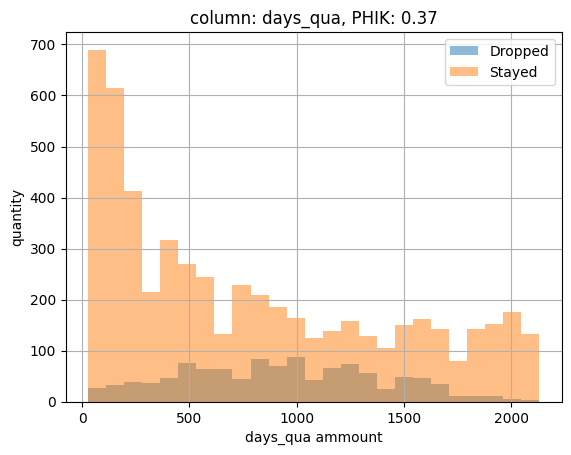

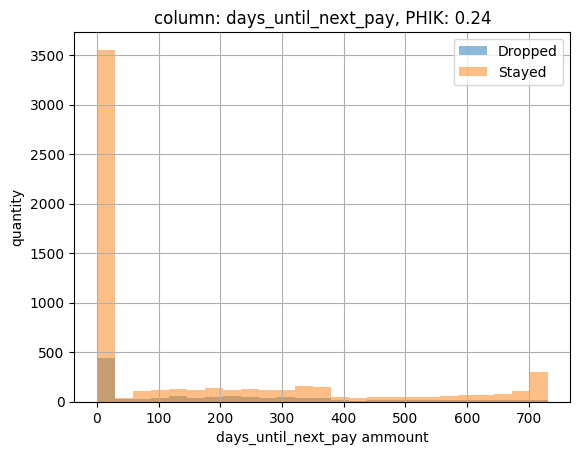

In [52]:
# Количественные признаки
columns_to_plot=data[cat+num+target].columns.get_indexer(num)

for i in columns_to_plot:
    n, bins, patches = plt.hist(dropped.iloc[:,i],
                                bins = 25,
                                alpha = 0.5,
                                label = 'Dropped')
    plt.hist(stayed.iloc[:,i],
             bins = bins,
             alpha = 0.5,
             label = 'Stayed')
    plt.legend()
    plt.xlabel(dropped.columns[i]+' ammount')
    plt.ylabel('quantity')
    plt.grid(True)
    plt.title(f"column: {dropped.columns[i]}, PHIK: {phik_overview[data[cat+num+target].columns[i]].loc['target'].round(2)}")
    plt.show()

Похоже, люди несколько чаще уходят с самого дешевого и дорогого месячного планов.  
Решение об уходе принимается незадолго от следующего платежа.

#### Категориальные признаки

In [53]:
def cat_bars(i, ax):
    '''
    Гистограммы для категориальных переменных
    '''
    unique_items = data.iloc[:, i].nunique()
    
    pivo = pd.pivot_table(data=data,
                          index='target',
                          columns=data.iloc[:, i],
                          values=data.columns[i],
                          aggfunc='count').reset_index()
    
    pivo.columns = ['target'] + [f'{data.columns[i]}_{j}' for j in range(unique_items)]
    
    bars = []
    for j in range(unique_items):
        bar = ax.bar(x=pivo['target'] - 0.1 * (unique_items - 1) / 2 + 0.1 * j,
                      height=pivo.iloc[:, j + 1],
                      width=0.2,
                      label=pivo.columns[j + 1])
        bars.append(bar)
    
    ax.set_xticks([0, 1])
    ax.set_ylabel('quantity')
    ax.set_xticklabels(['Stayed', 'Dropped'])
    ax.set_title(f"column: {data.columns[i]}, phik: {phik_overview[data.columns[i]].loc['target'].round(2)}")
    ax.grid(True)
    ax.legend()
    
    for bar in bars:
        ax.bar_label(bar)

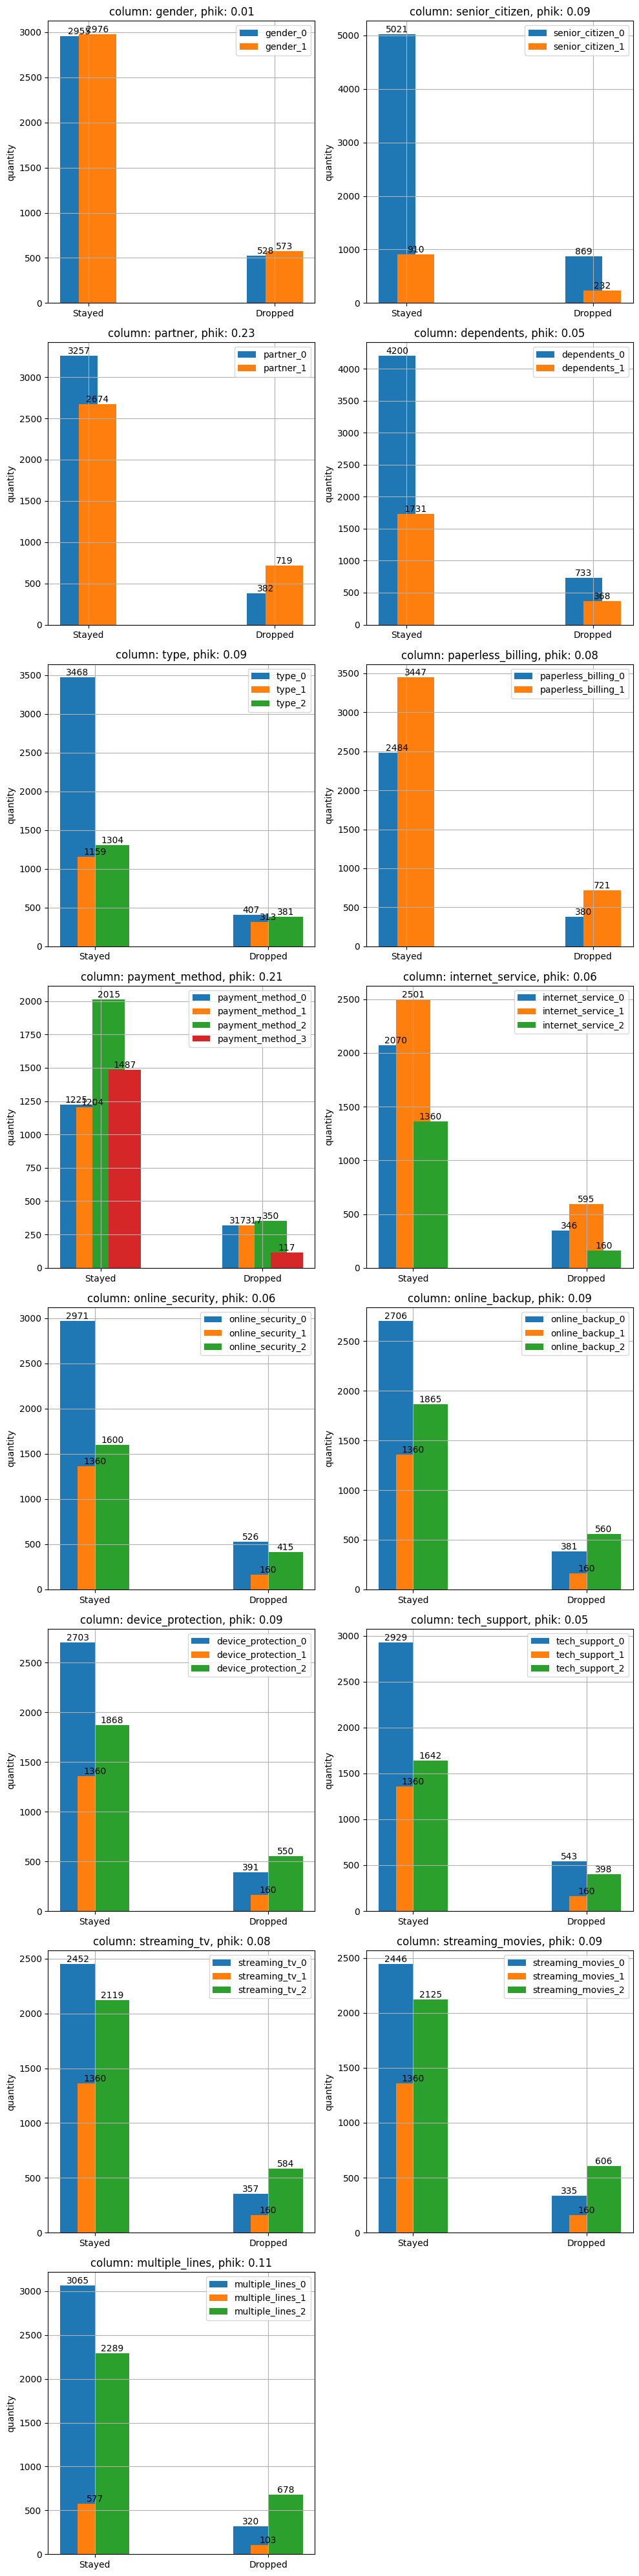

In [54]:
columns_to_plot=data.columns.get_indexer(cat)

fig, axes = plt.subplots(nrows=len(columns_to_plot) // 2 + len(columns_to_plot) % 2,
                         ncols=2,
                         figsize=(10, 5 * (len(columns_to_plot) // 2 + len(columns_to_plot) % 2)))

axes = axes.flatten()

for i, ax in zip(columns_to_plot, axes):
    cat_bars(i, ax)

if len(columns_to_plot) % 2 != 0:
    fig.delaxes(axes[-1])
    

plt.tight_layout()
plt.show()

Какое-то влияние на уход оказывает наличие партнера и способ оплаты.  
Попробую посмотреть на даты разрыва контрактов:

In [55]:
years = pd.to_datetime(data[data.end != '2020-02-01'].end).dt.year

In [56]:
years.value_counts()

end
2019    333
2018    285
2017    235
2016    140
2015     62
2020     39
2014      7
Name: count, dtype: int64

In [57]:
dt_index = pd.DatetimeIndex(data[data.end != '2020-02-01'].end)
months = dt_index.month

In [58]:
display(months.value_counts().sort_values(ascending=False))

end
11    113
12    107
9     105
1     103
10     99
7      97
6      87
3      86
8      82
5      81
4      71
2      70
Name: count, dtype: int64

Похоже, что клиенты чаще уходят ближе к концу года, начиная с октября и до января. 

In [59]:
data = data.drop('begin_date', axis=1)
data = data.drop('end_date', axis=1)
data = data.drop('end', axis=1)

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               7032 non-null   object 
 1   senior_citizen       7032 non-null   object 
 2   partner              7032 non-null   object 
 3   dependents           7032 non-null   object 
 4   type                 7032 non-null   object 
 5   paperless_billing    7032 non-null   object 
 6   payment_method       7032 non-null   object 
 7   monthly_charges      7032 non-null   float64
 8   total_charges        7032 non-null   float64
 9   target               7032 non-null   int64  
 10  days_qua             7032 non-null   float64
 11  days_until_next_pay  7032 non-null   float64
 12  internet_service     7032 non-null   object 
 13  online_security      7032 non-null   object 
 14  online_backup        7032 non-null   object 
 15  device_protection    7032 non-null   o

#### Подготовка данных (кодирование масштабирование)

In [61]:
# Разделю данные на выборки:
features = data.drop('target', axis=1)
target = data.target

In [62]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.25,
                                                                            random_state = RANDOM_STATE)

In [63]:
display(features_train.shape,
        target_train.shape,
        features_test.shape,
        target_test.shape)

(5274, 20)

(5274,)

(1758, 20)

(1758,)

In [64]:
display(target_train.value_counts(),
        target_test.value_counts())

target
0    4446
1     828
Name: count, dtype: int64

target
0    1485
1     273
Name: count, dtype: int64

##### Кодирование признаков

In [65]:
# OHE категориальных
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

In [66]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
encoder_ohe.fit(features_train_ohe[cat])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [67]:
features_train_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train_ohe[cat])

In [68]:
#dir(OneHotEncoder)

In [69]:
features_train_ohe = features_train_ohe.drop(cat, axis=1)

In [70]:
# Для числовых
scaler = StandardScaler()
features_train_ohe[num] = scaler.fit_transform(features_train_ohe[num])

In [71]:
display(features_train_ohe.head(3),
        features_train_ohe.shape)

,monthly_charges,total_charges,days_qua,days_until_next_pay,sevice_quantity,gender_Male,senior_citizen_Yes,partner_Yes,dependents_Yes,type_One year,...,device_protection_W/O,device_protection_Yes,tech_support_W/O,tech_support_Yes,streaming_tv_W/O,streaming_tv_Yes,streaming_movies_W/O,streaming_movies_Yes,multiple_lines_W/O,multiple_lines_Yes
3260,0.199064,0.100416,0.020450,-0.650641,0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4114,1.021424,0.357992,-0.024722,-0.655042,3,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2757,1.145773,0.169984,-0.202496,-0.584627,4,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


(5274, 31)

In [72]:
# Тестовая выборка:
features_test_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test_ohe[cat])

features_test_ohe = features_test_ohe.drop(cat, axis=1)

features_test_ohe[num] = scaler.transform(
    features_test_ohe[num]
)

# смотрим на результат
display(features_test_ohe.head(3),
        features_test_ohe.shape)

,monthly_charges,total_charges,days_qua,days_until_next_pay,sevice_quantity,gender_Male,senior_citizen_Yes,partner_Yes,dependents_Yes,type_One year,...,device_protection_W/O,device_protection_Yes,tech_support_W/O,tech_support_Yes,streaming_tv_W/O,streaming_tv_Yes,streaming_movies_W/O,streaming_movies_Yes,multiple_lines_W/O,multiple_lines_Yes
5880,-0.480710,-0.688252,-0.732901,-0.681447,3,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1022,1.500581,2.108730,1.349378,0.880867,6,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
6657,0.633456,0.067079,-0.113609,-0.659442,5,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


(1758, 31)

### Кластеризация

In [73]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.preprocessing import StandardScaler

Попробую кластеризировать клиентов, чтобы попытаться увидеть еще закономерности:

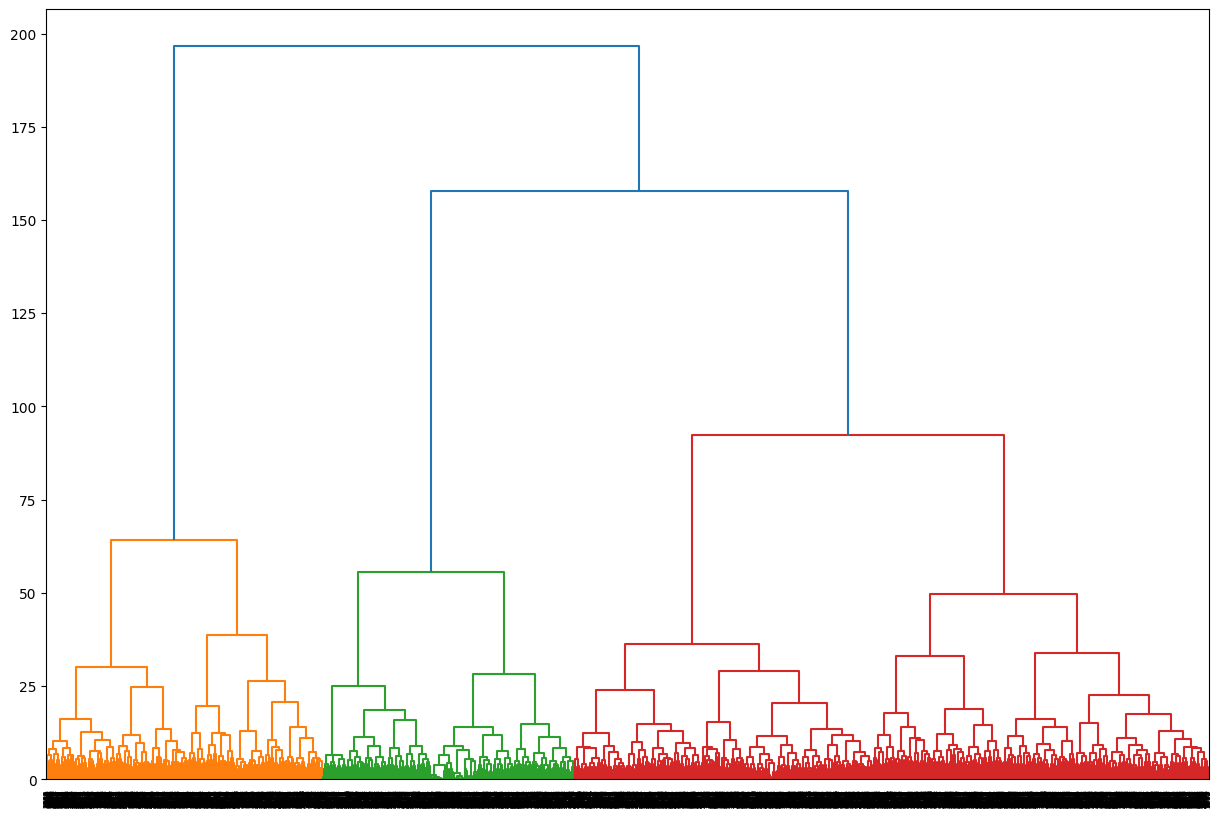

In [74]:
data_dend = features_train_ohe.copy()
#data_dend['target'] = target_train

linked = linkage(data_dend, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

In [75]:
cl = 3 # количество кластеров в соответствии с дендрограммой
km = KMeans(n_clusters = cl)
labels = km.fit_predict(data_dend)

In [76]:
data_dend['claster']= labels
data_dend['target'] = target_train 

In [77]:
piv = pd.pivot_table(data = data_dend,
                     index = 'claster',
                     columns = 'target',
                     values = 'gender_Male',
                     aggfunc = 'count' ).reset_index() 
piv.columns = ['claster','target_0','target_1']
piv['perc'] = piv['target_1']/(piv['target_0']+piv['target_1'])
piv['number']=piv['target_1']+piv['target_0']
print(piv.head())

   claster  target_0  target_1      perc  number
0        0      2127       299  0.123248    2426
1        1      1299       409  0.239461    1708
2        2      1020       120  0.105263    1140


In [78]:
pd.set_option('display.max_columns', None)
data_dend.groupby(by='claster').mean()

,monthly_charges,total_charges,days_qua,days_until_next_pay,sevice_quantity,gender_Male,senior_citizen_Yes,partner_Yes,dependents_Yes,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,internet_service_W/O,online_security_W/O,online_security_Yes,online_backup_W/O,online_backup_Yes,device_protection_W/O,device_protection_Yes,tech_support_W/O,tech_support_Yes,streaming_tv_W/O,streaming_tv_Yes,streaming_movies_W/O,streaming_movies_Yes,multiple_lines_W/O,multiple_lines_Yes,target
claster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.102681,-0.445655,-0.567657,-0.560751,1.465787,0.498351,0.198269,0.351195,0.207749,0.112119,0.022671,0.679308,0.145507,0.490107,0.204452,0.547403,0.0,0.0,0.203215,0.0,0.255153,0.0,0.228772,0.0,0.187139,0.0,0.296785,0.0,0.294724,0.145095,0.359439,0.123248
1,0.820728,1.102263,0.844440,0.585191,4.195550,0.502342,0.186183,0.666276,0.347775,0.326112,0.430913,0.669789,0.303864,0.289227,0.094848,0.583724,0.0,0.0,0.589578,0.0,0.696136,0.0,0.740632,0.0,0.626464,0.0,0.766393,0.0,0.776347,0.097775,0.635246,0.239461
2,-1.448164,-0.703076,-0.057163,0.316558,0.000000,0.508772,0.030702,0.478947,0.419298,0.219298,0.430702,0.294737,0.222807,0.074561,0.483333,0.000000,1.0,1.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.000000,0.000000,0.225439,0.105263


В 0 кластере отток больше, чем в остальных двух. Клиенты этого кластера имеют много подключенных сервисов, чаще подписаны на годовой план. Отделу маркетинга имеет смысл обратить внимание на таких людей.

---
**Промежуточный вывод:**  
Данные были просмотрены и подготовлены для обучения моделей. Анализ показывает, что клиенты чаще рассматривают отказ от услуг незадолго до даты следующего платежа.  
Были добавлены новые признаки, удалена часть старых. Создан новый датасет с закодированными и масштабированными признаками для обучения моделей.  

---

## Обучение моделей

Буду обучать следующие модели:  

- dummy - для сравнения результатов
- LinearSVC (с кластерами и без)
- RandomForest (с и без)
- LGBM
- CatBoost

#### Dummy

In [79]:
results=[]

In [80]:
clf=DummyClassifier(random_state=RANDOM_STATE)

start=time.time()
clf.fit(features_train_ohe, target_train)
end=time.time()
time_fit=end-start

dummy_predict=clf.predict(features_test_ohe)
dummy_roc = roc_auc_score(target_test, dummy_predict)
dummy_acc = accuracy_score(target_test, dummy_predict)

results.append(['dummy', time_fit, dummy_roc, dummy_acc])

#### LinearSVC

In [81]:
clf_svc=LinearSVC(class_weight = 'balanced', random_state=RANDOM_STATE)

In [82]:
parameters = [{'penalty': ['l1', 'l2']}, 
              {'C': [1, 5, 10, 15]}]

grid_search = GridSearchCV(estimator=clf_svc,  
                           param_grid=parameters,
                           scoring='roc_auc',
                           cv=5,
                           verbose=0)

In [83]:
grid_search.fit(features_train_ohe, target_train)

GridSearchCV(cv=5,
             estimator=LinearSVC(class_weight='balanced', random_state=220424),
             param_grid=[{'penalty': ['l1', 'l2']}, {'C': [1, 5, 10, 15]}],
             scoring='roc_auc')

In [84]:
grid_search.best_params_

{'penalty': 'l2'}

In [85]:
clf_svc=LinearSVC(penalty='l2',
                  C=1,
                  class_weight = 'balanced',
                  random_state=RANDOM_STATE)
start = time.time()
clf_svc.fit(features_train_ohe, target_train)
end = time.time()
time_fit = end - start


results.append(['LinearSVC',
                time_fit,
                grid_search.best_score_,
                cross_val_score(clf_svc,
                                features_train_ohe,
                                target_train,
                                cv=3,
                                scoring='accuracy').mean()])

In [86]:
# C кластерами
features_cl = data_dend.drop('target', axis=1)
target_cl = data_dend['target']

In [87]:
clf_svc=LinearSVC(class_weight = 'balanced', random_state=RANDOM_STATE)

parameters = [{'penalty': ['l1', 'l2']}, 
              {'C': [1, 5, 10, 15]}]

grid_search = GridSearchCV(estimator=clf_svc,  
                           param_grid=parameters,
                           scoring='roc_auc',
                           cv=5,
                           verbose=0)

In [88]:
grid_search.fit(features_cl, target_cl)
grid_search.best_params_

{'penalty': 'l2'}

In [89]:
clf_svc=LinearSVC(class_weight = 'balanced', C=1)
start = time.time()
clf_svc.fit(features_cl, target_cl)
end = time.time()
time_fit = end - start

results.append(['Linear_SVC+clasters',
                time_fit,
                grid_search.best_score_,
                cross_val_score(clf_svc,
                                features_cl,
                                target_cl,
                                cv=3,
                                scoring='accuracy').mean()])

#### RandomForestClassifier

In [90]:
clf_forest=RandomForestClassifier(class_weight = 'balanced', random_state=RANDOM_STATE)

In [91]:
parameters = {
    'n_estimators': np.arange(40, 100, 10),
    'max_depth' : np.arange(12, 24)
}

grid_search = GridSearchCV(clf_forest,
                           parameters,
                           cv=3, scoring=['roc_auc'],
                           refit = 'roc_auc')

In [92]:
grid_search.fit(features_train_ohe, target_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=220424),
             param_grid={'max_depth': array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]),
                         'n_estimators': array([40, 50, 60, 70, 80, 90])},
             refit='roc_auc', scoring=['roc_auc'])

In [93]:
grid_search.best_params_

{'max_depth': 12, 'n_estimators': 80}

In [94]:
clf_forest=RandomForestClassifier(max_depth=17, n_estimators=90, class_weight = 'balanced', random_state=RANDOM_STATE)
start = time.time()
clf_forest.fit(features_train_ohe, target_train)
end = time.time()
time_fit = end - start

results.append(['RandomForest',
                time_fit,
                grid_search.best_score_,
                cross_val_score(clf_forest,
                                features_train_ohe,
                                target_train,
                                cv=3,
                                scoring='accuracy').mean()])

In [95]:
# +cl
grid_search.fit(features_cl, target_cl)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=220424),
             param_grid={'max_depth': array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]),
                         'n_estimators': array([40, 50, 60, 70, 80, 90])},
             refit='roc_auc', scoring=['roc_auc'])

In [96]:
clf_forest=RandomForestClassifier(max_depth=12, n_estimators=60, class_weight = 'balanced')
start = time.time()
clf_forest.fit(features_cl, target_cl)
end = time.time()
time_fit = end - start

results.append(['RandomForest+clasters',
                time_fit,
                grid_search.best_score_,
                cross_val_score(clf_forest,
                                features_train_ohe,
                                target_train,
                                cv=3,
                                scoring='accuracy').mean()])

#### LGBM

In [97]:
clf_lgbm = LGBMClassifier(random_state=RANDOM_STATE)

In [98]:
parameters = {
    'lgbm__n_estimators': [50, 100, 150],
    'lgbm__max_depth': [3, 5, 7],
    'lgbm__learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(clf_lgbm,
                           parameters,
                           scoring='roc_auc',
                           verbose=0)

In [99]:
%%capture
grid_search.fit(features_train_ohe, target_train)

In [100]:
grid_search.best_params_

{'lgbm__learning_rate': 0.01, 'lgbm__max_depth': 3, 'lgbm__n_estimators': 50}

In [101]:
%%capture
clf_lgbm=LGBMClassifier(learning_rate=0.01, max_depth=3, n_estimators=50, random_state=RANDOM_STATE)

start = time.time()
clf_lgbm.fit(features_train_ohe, target_train)
end = time.time()
time_fit = end - start

results.append(['LGBMClassifier',
                time_fit,
                grid_search.best_score_,
                cross_val_score(clf_lgbm,
                                features_train_ohe,
                                target_train,
                                cv=3,
                                scoring='accuracy').mean()])

#### Catboost

Воспользуюсь встроенным кодировщиком

In [102]:
clf_cat=CatBoostClassifier(logging_level='Silent',
                           loss_function='Logloss',
                           one_hot_max_size=5,
                           cat_features=cat,
                          random_state=RANDOM_STATE)

In [103]:
parameters = {'max_depth': np.arange(4, 11),
              'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1],
              'iterations': [500,1000,1500,2000]}

catboost_grid = GridSearchCV(clf_cat,
                             parameters,
                             cv=3,
                             scoring=['roc_auc', 'precision'],
                             refit = 'roc_auc'
                             
                            )

In [104]:
%%time

catboost_grid.fit(features_train, target_train)

CPU times: total: 4h 8min 11s
Wall time: 31min 16s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000002DCCB092810>,
             param_grid={'iterations': [500, 1000, 1500, 2000],
                         'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1],
                         'max_depth': array([ 4,  5,  6,  7,  8,  9, 10])},
             refit='roc_auc', scoring=['roc_auc', 'precision'])

In [105]:
catboost_grid.best_params_

{'iterations': 2000, 'learning_rate': 0.1, 'max_depth': 4}

In [106]:
clf_cat=CatBoostClassifier(logging_level='Silent',
                           loss_function='Logloss',
                           one_hot_max_size=5,
                           iterations=1000,
                           learning_rate=0.1,
                           max_depth=4,
                          cat_features=cat,
                          random_state=RANDOM_STATE)

start = time.time()
clf_cat.fit(features_train, target_train)
end = time.time()
time_fit = end - start

results.append(['Catboost',
                time_fit,
                catboost_grid.best_score_,
                cross_val_score(clf_cat,
                                features_train,
                                target_train,
                                cv=3,
                                scoring='accuracy').mean()])

### Оценка моделей

In [107]:
results=pd.DataFrame(results, columns=['model', 'time_fit', 'roc_auc', 'accuracy'])
results

,model,time_fit,roc_auc,accuracy
0,dummy,0.000997,0.500000,0.844710
1,LinearSVC,0.245696,0.778778,0.721085
2,Linear_SVC+clasters,0.253938,0.777836,0.722601
3,RandomForest,0.375082,0.826715,0.856845
4,RandomForest+clasters,0.218832,0.823235,0.845279
5,LGBMClassifier,0.030114,0.887741,0.843003
6,Catboost,1.878263,0.906504,0.912780


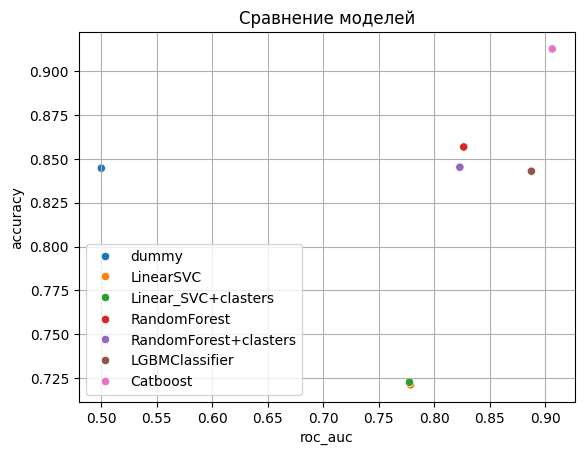

In [108]:
sns.scatterplot(data=results,
                x = 'roc_auc',
                y = 'accuracy',
                hue=list(results.model))
plt.grid(True)
plt.title('Сравнение моделей')
plt.legend()
plt.show();

По результам на кросс-валидации лучший результат получает CatBoost модель. Именно её буду использовать на тестовой выборке.

## Тестирование

In [109]:
pred = clf_cat.predict_proba(features_test)[:, 1]
pred

array([0.53634097, 0.27563958, 0.40031327, ..., 0.01145926, 0.15648493,
       0.40066032])

In [110]:
roc_auc_score(target_test, pred)

0.9311897978564645

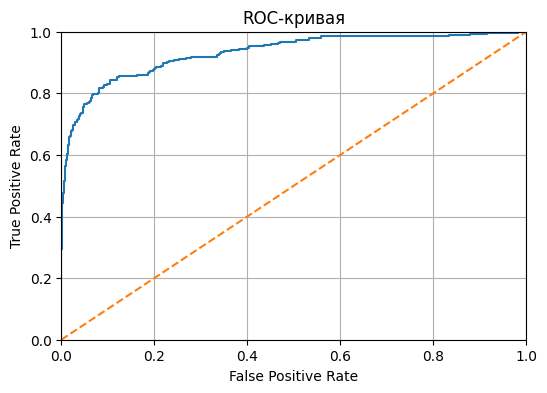

In [111]:
fpr, tpr, thresholds = roc_curve(target_test, pred)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.grid(True)

plt.show()

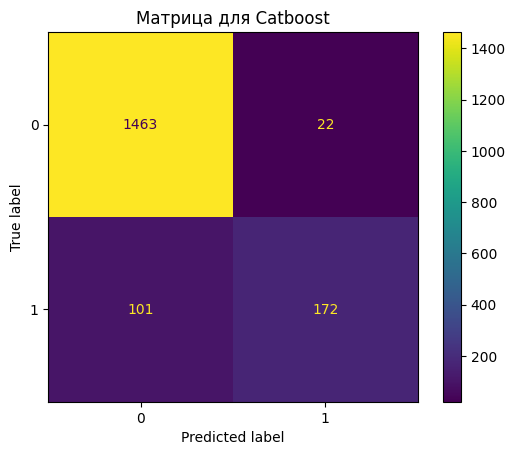

In [112]:
cm = confusion_matrix(target_test, clf_cat.predict(features_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();
disp.ax_.set_title('Матрица для Catboost');

In [113]:
#pd.DataFrame({'feature': features_train.columns,
#              'importance': clf_cat.feature_importances_}) \
#              .sort_values('importance', ascending = False).head(5)

In [114]:
%%capture
!pip install shap

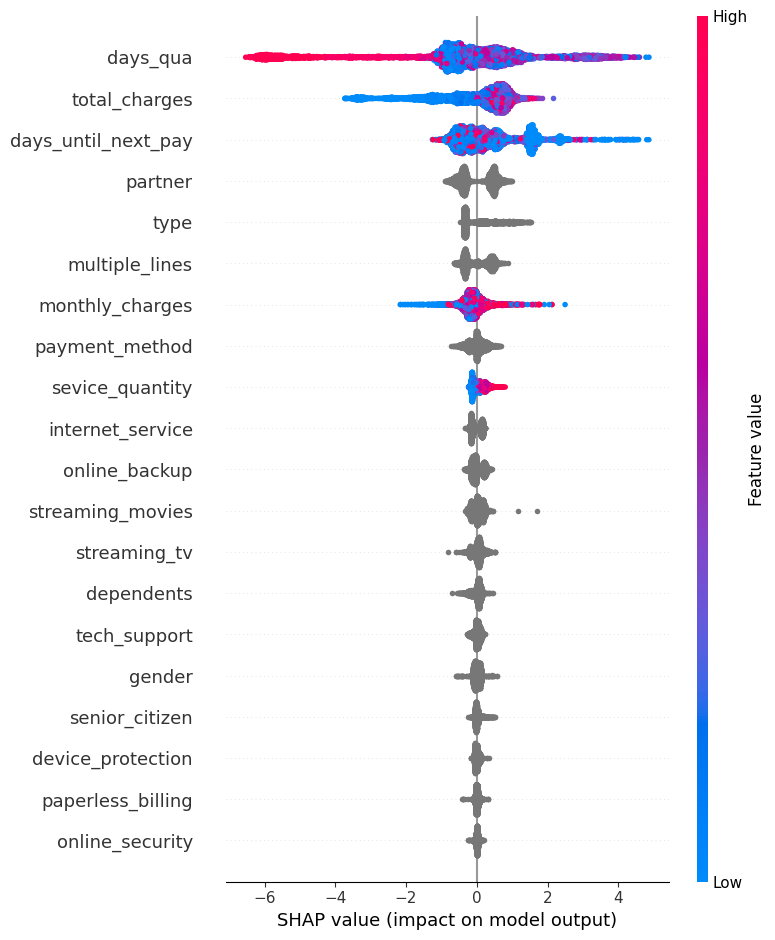

In [115]:
import shap

shap_test = shap.TreeExplainer(clf_cat).shap_values(features_train)
shap.summary_plot(shap_test, features_train,
                      max_display=25, auto_size_plot=True)

Результат ROC_AUC>=0.85 достигнут и на кросс-валидации и на тестовой выборке.  
Важными признаками оказались заново созданные количество дней контракта и количество днй до следующего платежа (чем меньше, тем больше вероятность ухода).   
Старые клиенты больше лояльны и реже разрывают контракт (days_qua) как и те, у кого низкий чек за всё время (total_charges).  

## Вывод

Оператор связи «ТелеДом» предоставил персональные данные о некоторых клиентах, информацию об их тарифах и услугах.  
**Цель работы:** создание модели, которая будет предсказывать, разорвёт ли абонент договор.

---
В ходе работы была проведена предобработка данных, в том числе:  

- Были заменены типы некоторых данных, заполнены пропуски;
- Были созданы вспомогательные столбцы, например количество подключенных сервисов клиента, длительность его контракта в днях, количество дней до следующего платежа;
- Был собран общий датасет из всех предоставленных данных, после чего признаки были закодированы и масштабированы.  

Были обучены несколько моделей машинного обучения. После сравнения их результатов, лучший показатель ROC_AUC (по условию заказчика), показала модель **CatBoost** cо следующими гиперпараметрами:

{'iterations': 2000, 'learning_rate': 0.1, 'max_depth': 4}
по важности признаков в модели 
Первые места занимают дни до следующего платежа и общее число дней контракта, третье и четвертое - оплата всего и в месяц.  
Модель достигла необходимого результата **ROC_AUC>=0.85**. Модель лучше предсказывает клиентов, которые останутся в компании (1459/102), чем желающих уйти (171/26).   
Для улучшения качества модели можно попробовать собрать данные за более длительный срок/добавить информацию о проходящих акциях, чтобы оценить их влияние на желание клиентов остаться. 

---
**Дополнительно:**   

Проведенный анализ данных позволяет сделать несоклько предположений (требует дальнейшей проверки), а именно:  
- Решение об уходе клиент скорее принимает незадолго до даты следующего платежа - эти сроки следует учитывать при отправке предложений.  
- Так же в группе риска находятся люди с большим количеством подключенных сервисов, использующие годовой план, возможно, при уменьшении количества сервисов/получении скидки на доп услуги они могли бы остаться. 
- Также наблюдается повышение оттока клиентов в осенне-зимний период, возможно стоит проводить какие-то акции в это время года.  
ции в это время года.  
